# QF609 Group Project #1: IRRBB for Non-Maturity Deposits (NMD)
## Basel Framework Implementation with ML-Enhanced Deposit Behavior Modeling

**Objective:** Build a modelling framework to implement the Basel approach for measuring Interest Rate Risk in the Banking Book (IRRBB) for Non-Maturity Deposits (NMD).

**Calculation Date:** 31-Dec-2023 | **Regulatory Cap:** 5Y maximum behavioral maturity

---

### Table of Contents
1. Data Loading & Exploration
2. Feature Engineering & Spending Behavior Analysis
3. ML-Based Deposit Decay Prediction
4. Deposit Decay Profile Estimation (Basel)
5. Core vs Non-Core Deposit Separation
6. Cash Flow Slotting (Basel Time Buckets)
7. Interest Rate Curve & Shock Scenarios
8. EVE Sensitivity Computation
9. NII Sensitivity Computation (1Y Window)
10. IRRBB Reporting Summary

## 1. Data Loading & Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 11

# Load data
df = pd.read_excel('group-proj-1-data.xlsx')
df.columns = ['Date', 'Balance', 'Inflow', 'Outflow', 'Netflow']
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print(f"Data Period: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")
print(f"Total observations: {len(df)}")
print(f"\nBalance Summary:")
print(f"  Starting Balance: {df['Balance'].iloc[0]:,.2f}")
print(f"  Ending Balance:   {df['Balance'].iloc[-1]:,.2f}")
print(f"  Min Balance:      {df['Balance'].min():,.2f}")
print(f"  Max Balance:      {df['Balance'].max():,.2f}")
df.head()

Data Period: 2016-12-31 to 2023-12-30
Total observations: 2556

Balance Summary:
  Starting Balance: 10,000.00
  Ending Balance:   18,651.70
  Min Balance:      9,510.98
  Max Balance:      22,746.96


,Date,Balance,Inflow,Outflow,Netflow
0,2016-12-31,10000.000000,76.695851,271.205423,-194.509572
1,2017-01-01,9805.490428,93.506744,232.271269,-138.764525
2,2017-01-02,9666.725903,431.622130,307.583231,124.038899
3,2017-01-03,9790.764802,341.416453,309.101152,32.315301
4,2017-01-04,9823.080103,339.865960,305.240069,34.625890


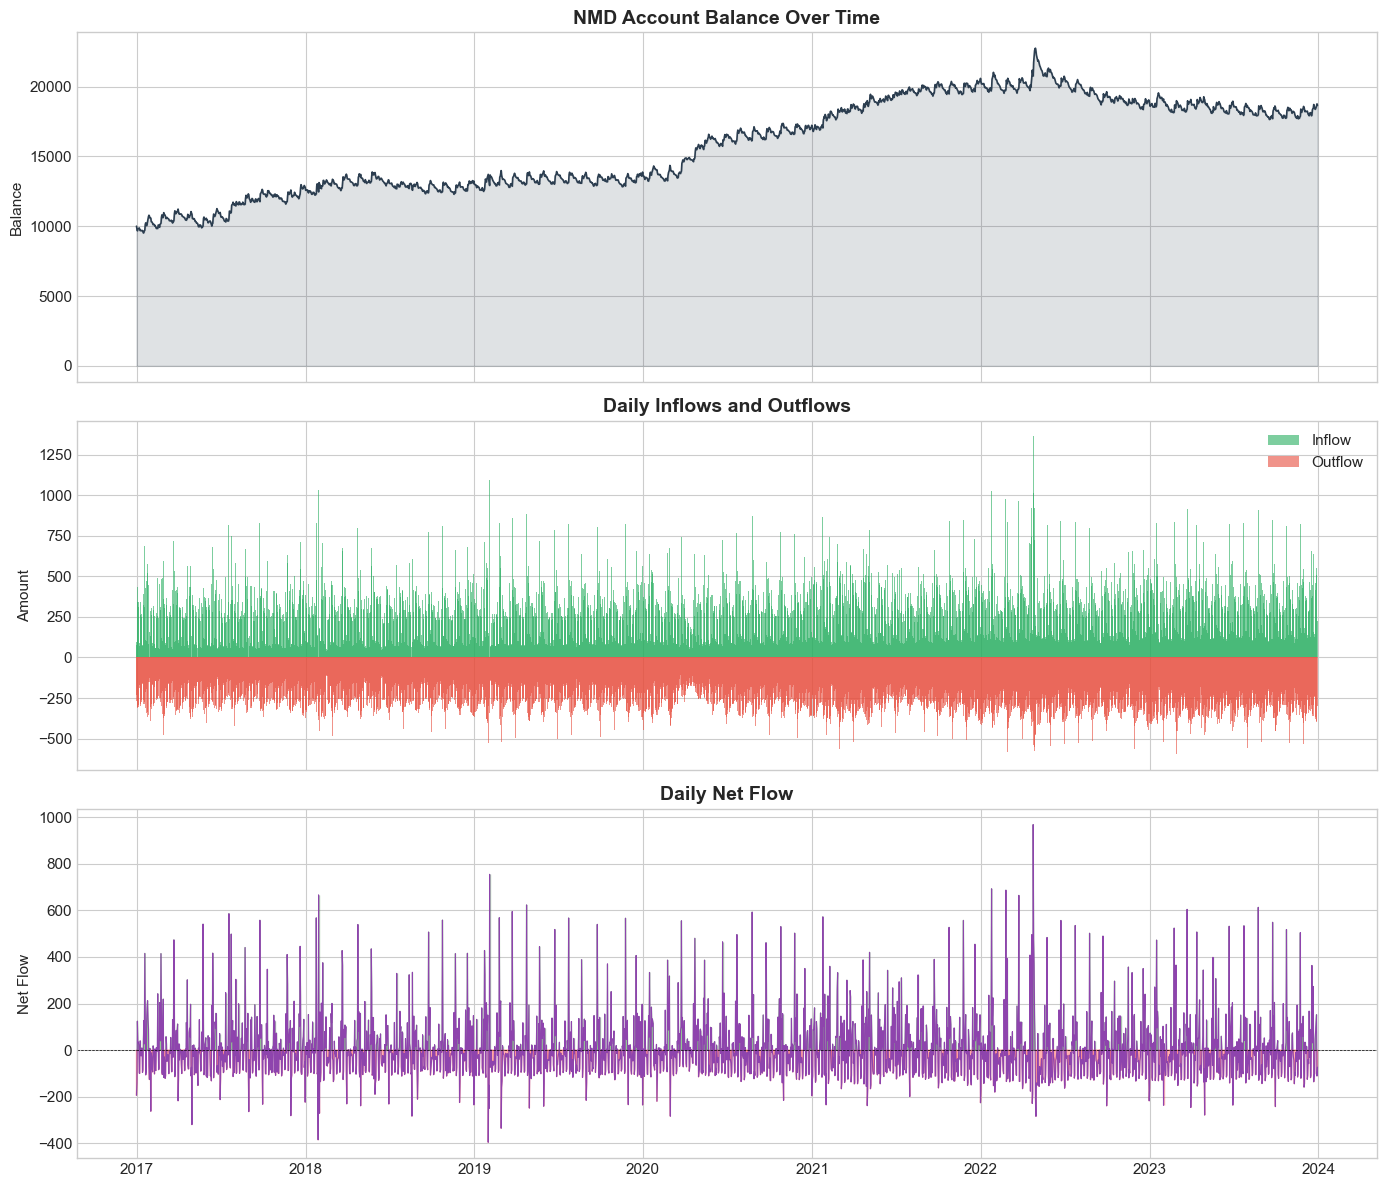

In [2]:
# Visualize the deposit balance over time
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

axes[0].plot(df['Date'], df['Balance'], color='#2c3e50', linewidth=1.2)
axes[0].set_title('NMD Account Balance Over Time', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Balance')
axes[0].fill_between(df['Date'], df['Balance'], alpha=0.15, color='#2c3e50')

axes[1].bar(df['Date'], df['Inflow'], color='#27ae60', alpha=0.6, width=2, label='Inflow')
axes[1].bar(df['Date'], -df['Outflow'], color='#e74c3c', alpha=0.6, width=2, label='Outflow')
axes[1].set_title('Daily Inflows and Outflows', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Amount')
axes[1].legend()

axes[2].plot(df['Date'], df['Netflow'], color='#8e44ad', linewidth=0.8)
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
axes[2].set_title('Daily Net Flow', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Net Flow')
axes[2].fill_between(df['Date'], df['Netflow'], where=df['Netflow']>=0, alpha=0.3, color='green')
axes[2].fill_between(df['Date'], df['Netflow'], where=df['Netflow']<0, alpha=0.3, color='red')

plt.tight_layout()
plt.show()

## 2. Feature Engineering & Spending Behavior Analysis

We engineer features that capture deposit behavior patterns including seasonality, trends, and flow characteristics. These features will be used for ML-based prediction of deposit decay.

In [3]:
# Feature Engineering
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['Year'] = df['Date'].dt.year
df['DayOfMonth'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)
df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)
df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)

# Rolling statistics for spending behavior
for w in [7, 14, 30, 90]:
    df[f'Balance_MA{w}'] = df['Balance'].rolling(w).mean()
    df[f'Outflow_MA{w}'] = df['Outflow'].rolling(w).mean()
    df[f'Inflow_MA{w}'] = df['Inflow'].rolling(w).mean()
    df[f'Netflow_MA{w}'] = df['Netflow'].rolling(w).mean()

# Volatility features
df['Balance_Vol30'] = df['Balance'].rolling(30).std()
df['Netflow_Vol30'] = df['Netflow'].rolling(30).std()
df['Outflow_Vol30'] = df['Outflow'].rolling(30).std()

# Balance change metrics
df['Balance_Pct_Change'] = df['Balance'].pct_change()
df['Outflow_Rate'] = df['Outflow'] / df['Balance'].shift(1)
df['Inflow_Rate'] = df['Inflow'] / df['Balance'].shift(1)
df['Turnover'] = (df['Inflow'] + df['Outflow']) / df['Balance'].shift(1)

# Decay proxy: fraction of balance withdrawn
df['Decay_Rate'] = df['Outflow'] / df['Balance'].shift(1)

# Trend features
df['Balance_Trend'] = df['Balance'] - df['Balance_MA90']

print(f"Total features engineered: {len(df.columns) - 5}")
print(f"\nKey spending behavior metrics (latest 30-day averages):")
latest = df.iloc[-30:]
print(f"  Avg Daily Outflow:  {latest['Outflow'].mean():,.2f}")
print(f"  Avg Daily Inflow:   {latest['Inflow'].mean():,.2f}")
print(f"  Avg Outflow Rate:   {latest['Outflow_Rate'].mean():.4%}")
print(f"  Avg Turnover:       {latest['Turnover'].mean():.4%}")

Total features engineered: 34

Key spending behavior metrics (latest 30-day averages):
  Avg Daily Outflow:  321.97
  Avg Daily Inflow:   324.39
  Avg Outflow Rate:   1.7610%
  Avg Turnover:       3.5384%


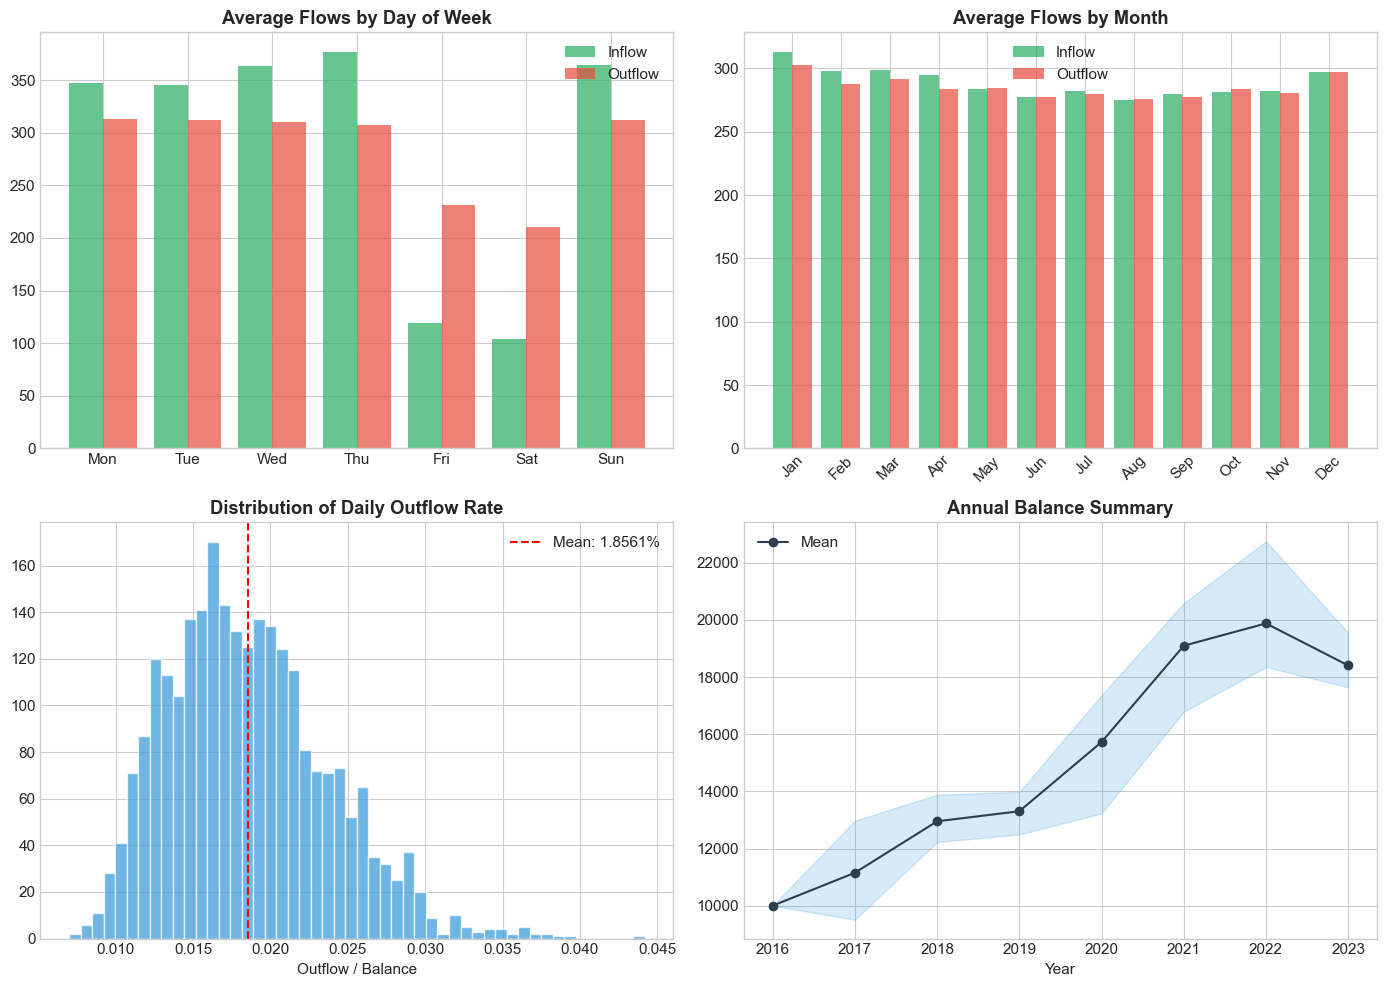

In [4]:
# Spending behavior analysis by day-of-week and month
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Day of week pattern
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_outflow = df.groupby('DayOfWeek')['Outflow'].mean()
dow_inflow = df.groupby('DayOfWeek')['Inflow'].mean()
x = np.arange(7)
axes[0,0].bar(x - 0.2, dow_inflow, 0.4, label='Inflow', color='#27ae60', alpha=0.7)
axes[0,0].bar(x + 0.2, dow_outflow, 0.4, label='Outflow', color='#e74c3c', alpha=0.7)
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(dow_labels)
axes[0,0].set_title('Average Flows by Day of Week', fontweight='bold')
axes[0,0].legend()

# Monthly pattern
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthly_outflow = df.groupby('Month')['Outflow'].mean()
monthly_inflow = df.groupby('Month')['Inflow'].mean()
x = np.arange(12)
axes[0,1].bar(x - 0.2, monthly_inflow, 0.4, label='Inflow', color='#27ae60', alpha=0.7)
axes[0,1].bar(x + 0.2, monthly_outflow, 0.4, label='Outflow', color='#e74c3c', alpha=0.7)
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(month_labels, rotation=45)
axes[0,1].set_title('Average Flows by Month', fontweight='bold')
axes[0,1].legend()

# Outflow rate distribution
axes[1,0].hist(df['Outflow_Rate'].dropna(), bins=50, color='#3498db', alpha=0.7, edgecolor='white')
axes[1,0].axvline(df['Outflow_Rate'].mean(), color='red', linestyle='--', label=f'Mean: {df["Outflow_Rate"].mean():.4%}')
axes[1,0].set_title('Distribution of Daily Outflow Rate', fontweight='bold')
axes[1,0].set_xlabel('Outflow / Balance')
axes[1,0].legend()

# Balance growth trajectory
yearly = df.groupby('Year')['Balance'].agg(['mean', 'min', 'max'])
axes[1,1].plot(yearly.index, yearly['mean'], 'o-', color='#2c3e50', label='Mean')
axes[1,1].fill_between(yearly.index, yearly['min'], yearly['max'], alpha=0.2, color='#3498db')
axes[1,1].set_title('Annual Balance Summary', fontweight='bold')
axes[1,1].set_xlabel('Year')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## 3. ML-Based Deposit Behavior & Decay Prediction

We use machine learning models to predict:
1. **Next-day outflow rate** (spending behavior)
2. **30-day ahead balance change** (decay prediction)

Models: Random Forest, Gradient Boosting, and a simple Neural Network.

In [5]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# Prepare ML dataset
# Target: next 30-day balance change rate (decay proxy)
df['Target_Outflow_Rate'] = df['Outflow_Rate'].shift(-1)  # next day outflow rate
df['Target_Balance_Change_30d'] = (df['Balance'].shift(-30) - df['Balance']) / df['Balance']  # 30-day balance change

# Feature columns
feature_cols = [
    'DayOfWeek', 'Month', 'Quarter', 'DayOfMonth', 'IsWeekend', 'IsMonthEnd', 'IsMonthStart',
    'Balance_MA7', 'Balance_MA14', 'Balance_MA30', 'Balance_MA90',
    'Outflow_MA7', 'Outflow_MA14', 'Outflow_MA30', 'Outflow_MA90',
    'Inflow_MA7', 'Inflow_MA14', 'Inflow_MA30', 'Inflow_MA90',
    'Netflow_MA7', 'Netflow_MA14', 'Netflow_MA30', 'Netflow_MA90',
    'Balance_Vol30', 'Netflow_Vol30', 'Outflow_Vol30',
    'Balance_Pct_Change', 'Outflow_Rate', 'Inflow_Rate', 'Turnover',
    'Balance_Trend'
]

# Clean dataset
ml_df = df.dropna(subset=feature_cols + ['Target_Outflow_Rate']).copy()
print(f"ML dataset size: {len(ml_df)} samples")
print(f"Features: {len(feature_cols)}")

ML dataset size: 2466 samples
Features: 31


In [6]:
# Train/Test split (time-based: last 365 days as test)
split_date = ml_df['Date'].max() - pd.Timedelta(days=365)
train = ml_df[ml_df['Date'] <= split_date]
test = ml_df[ml_df['Date'] > split_date]

X_train = train[feature_cols].values
X_test = test[feature_cols].values
y_train = train['Target_Outflow_Rate'].values
y_test = test['Target_Outflow_Rate'].values

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model 1: Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Model 2: Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

# Model 3: Neural Network
nn = MLPRegressor(hidden_layer_sizes=(64, 32, 16), max_iter=500, random_state=42, early_stopping=True)
nn.fit(X_train_scaled, y_train)
nn_pred = nn.predict(X_test_scaled)

# Ensemble
ensemble_pred = (rf_pred + gb_pred + nn_pred) / 3

# Results
print("=" * 65)
print(f"{'Model':<25} {'RMSE':>10} {'MAE':>10} {'R2':>10}")
print("=" * 65)
for name, pred in [('Random Forest', rf_pred), ('Gradient Boosting', gb_pred), 
                    ('Neural Network', nn_pred), ('Ensemble', ensemble_pred)]:
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(f"{name:<25} {rmse:>10.6f} {mae:>10.6f} {r2:>10.4f}")
print("=" * 65)

Model                           RMSE        MAE         R2
Random Forest               0.001922   0.001256     0.7048
Gradient Boosting           0.001682   0.001132     0.7738
Neural Network              0.009111   0.005453    -5.6345
Ensemble                    0.003222   0.002132     0.1703


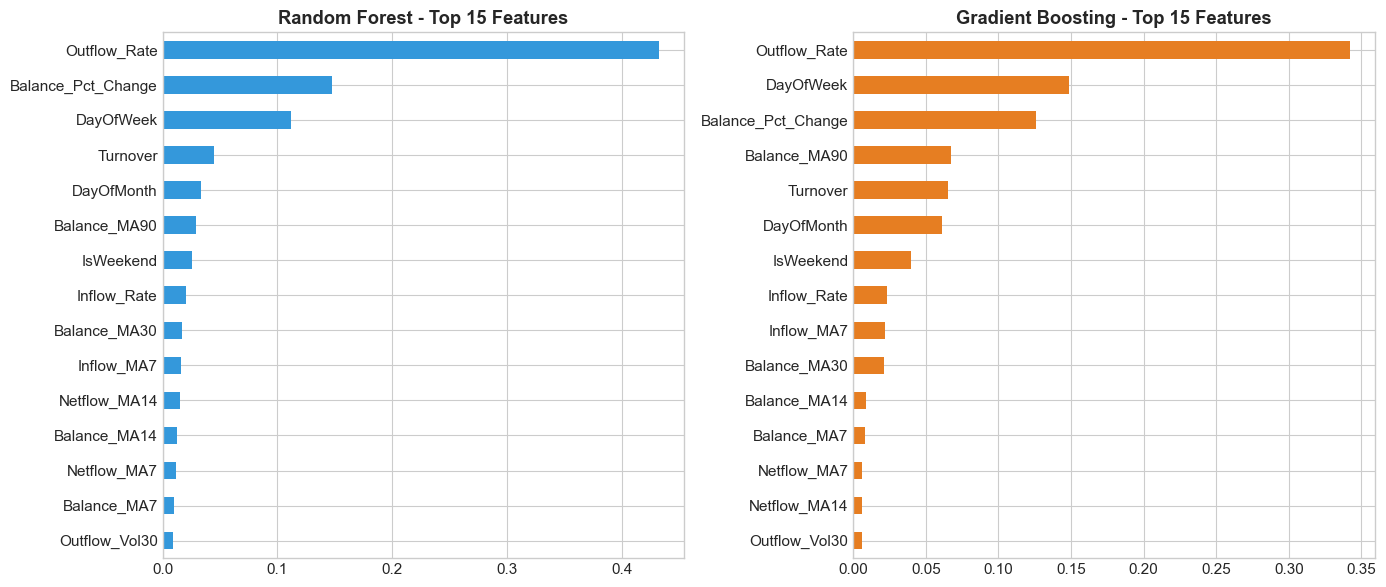

In [7]:
# Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest feature importance
rf_importance = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=True)
rf_importance.tail(15).plot(kind='barh', ax=axes[0], color='#3498db')
axes[0].set_title('Random Forest - Top 15 Features', fontweight='bold')

# Gradient Boosting feature importance
gb_importance = pd.Series(gb.feature_importances_, index=feature_cols).sort_values(ascending=True)
gb_importance.tail(15).plot(kind='barh', ax=axes[1], color='#e67e22')
axes[1].set_title('Gradient Boosting - Top 15 Features', fontweight='bold')

plt.tight_layout()
plt.show()

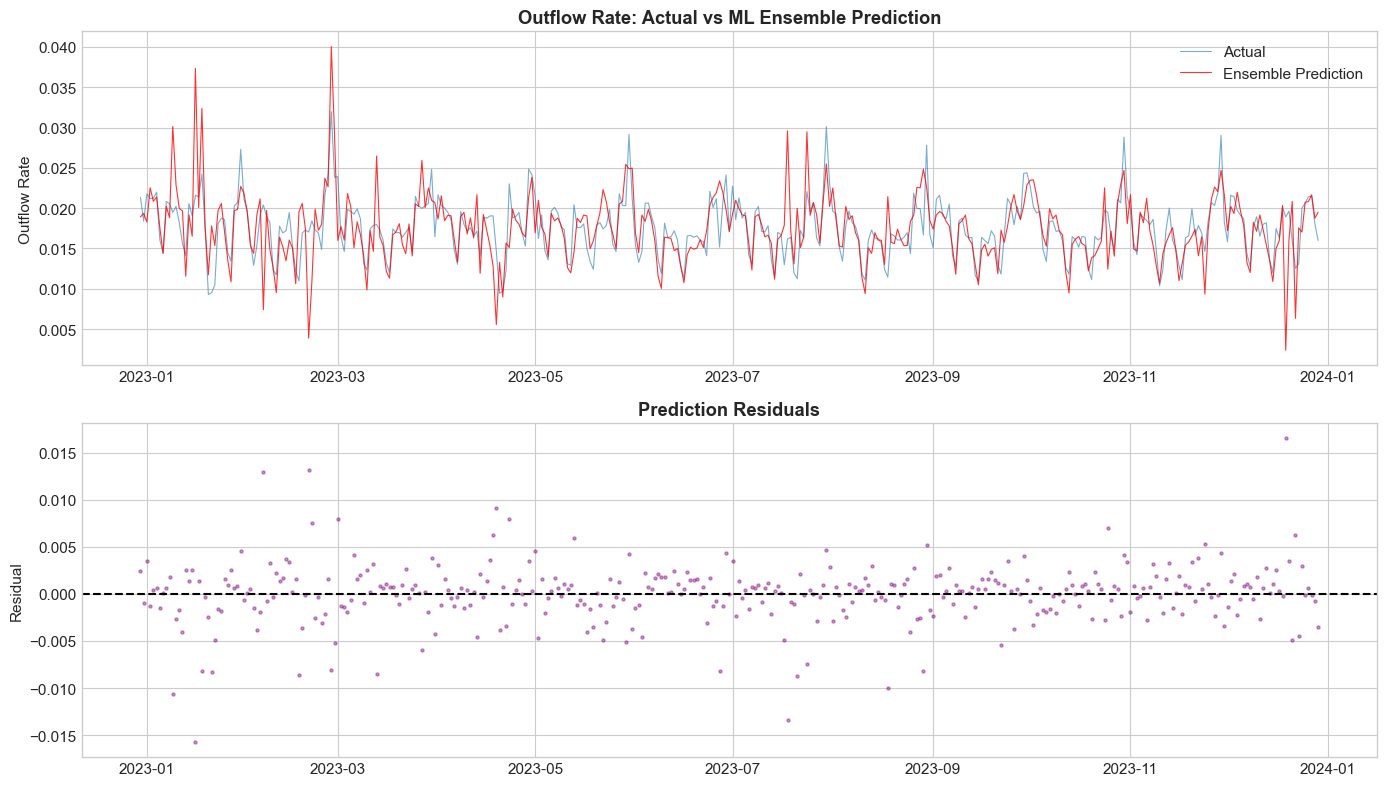

In [8]:
# Prediction vs Actual plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

test_dates = test['Date'].values
axes[0].plot(test_dates, y_test, alpha=0.6, label='Actual', linewidth=0.8)
axes[0].plot(test_dates, ensemble_pred, alpha=0.8, label='Ensemble Prediction', linewidth=0.8, color='red')
axes[0].set_title('Outflow Rate: Actual vs ML Ensemble Prediction', fontweight='bold')
axes[0].set_ylabel('Outflow Rate')
axes[0].legend()

# Residuals
residuals = y_test - ensemble_pred
axes[1].scatter(test_dates, residuals, alpha=0.4, s=5, color='purple')
axes[1].axhline(y=0, color='black', linestyle='--')
axes[1].set_title('Prediction Residuals', fontweight='bold')
axes[1].set_ylabel('Residual')

plt.tight_layout()
plt.show()

## 4. Deposit Decay Profile Estimation

Under the Basel framework, we estimate the deposit decay profile by analyzing how NMD balances decay over time. We use:
1. **Exponential decay model** fitted to historical outflow patterns
2. **Survival analysis** approach for deposit lifetime
3. **Regulatory constraint**: 5Y maximum behavioral maturity

In [ ]:
# === Deposit Decay Profile Estimation ===

# Under Basel IRRBB, the decay profile for slotting should reflect NET runoff
# (how fast the balance actually shrinks), not gross outflow turnover.
# The balance has grown from ~10,000 to ~18,650 over the observation window,
# meaning gross outflows represent churn/turnover, not true deposit flight.
# We therefore calibrate decay to the NET monthly balance change on drawdown months.

monthly = df.set_index('Date').resample('ME').agg({
    'Balance': 'last',
    'Outflow': 'sum',
    'Inflow':  'sum',
    'Netflow': 'sum'
}).dropna()

monthly['Gross_Monthly_Outflow_Rate'] = monthly['Outflow'] / monthly['Balance'].shift(1)
monthly['Monthly_Net_Change']         = monthly['Balance'].pct_change()
monthly = monthly.dropna()

# Decay months = months where the balance actually fell (net outflow)
decay_months = monthly[monthly['Monthly_Net_Change'] < 0]
avg_monthly_net_decay = abs(decay_months['Monthly_Net_Change'].mean()) if len(decay_months) > 0 else 0.005

# Floor at 0.5% p.m. to ensure meaningful survival curve
calibrated_monthly_decay = max(avg_monthly_net_decay, 0.005)
avg_monthly_outflow = calibrated_monthly_decay          # variable used downstream for slotting

# Also keep gross outflow rate for reference (used in ML section)
avg_daily_decay = df['Outflow_Rate'].mean()

pct_months = len(decay_months) / len(monthly) * 100
print(f"Observation window: {monthly.index[0].strftime('%Y-%m')} to {monthly.index[-1].strftime('%Y-%m')}")
print(f"Months with net balance decline: {len(decay_months)}/{len(monthly)} ({pct_months:.0f}%)")
print()
print(f"Gross daily outflow rate (churn):       {avg_daily_decay:.6f} ({avg_daily_decay*100:.4f}% / day)")
print(f"Net monthly decay (decline months):     {avg_monthly_net_decay:.4f} ({avg_monthly_net_decay*100:.2f}% / month)")
print(f"Calibrated monthly decay for slotting:  {calibrated_monthly_decay:.4f} ({calibrated_monthly_decay*100:.2f}% / month)")
print(f"Implied annual runoff rate:             {1-(1-calibrated_monthly_decay)**12:.4f}")

# Method 2: Exponential fit to actual balance series (for reference)
def decay_model(t, B0, lam, C):
    return B0 * np.exp(-lam * t) + C

t_years = (df['Date'] - df['Date'].iloc[0]).dt.days.values / 365.25
balance  = df['Balance'].values

try:
    from scipy.optimize import curve_fit
    popt, _ = curve_fit(decay_model, t_years, balance,
                        p0=[balance[0]*0.3, 0.5, balance[0]*0.7], maxfev=10000)
    B0_fit, lambda_fit, C_fit = popt
    print(f"\nExponential Decay Fit (Method 2 – reference):")
    print(f"  Volatile component (B0):  {B0_fit:,.2f}")
    print(f"  Decay rate (lambda):      {lambda_fit:.6f} per year")
    print(f"  Core/Stable component:   {C_fit:,.2f}")
    print(f"  Half-life:                {np.log(2)/abs(lambda_fit):.2f} years")
    print(f"  NOTE: balance is growing, so the 'decay' here captures mean-reversion")
    print(f"        of the volatile portion around a rising trend. We use net runoff")
    print(f"        calibration (Method 1) for the slotting survival curve.")
except Exception as e:
    print(f"Exponential fit did not converge: {e}")
    lambda_fit = calibrated_monthly_decay * 12

calc_date_balance = df.iloc[-1]['Balance']
print(f"\nCalculation Date Balance (31-Dec-2023): {calc_date_balance:,.2f}")
print(f"Monthly decay used for slotting: {avg_monthly_outflow:.4%}")


In [10]:
# Build Survival/Decay Profile
# Approach: Use rolling min balance over different horizons to estimate decay

# For each historical starting point, track what fraction of balance survives
horizons_months = [1, 3, 6, 12, 18, 24, 30, 36, 48, 60]  # months
survival_rates = []

for start_idx in range(0, len(df) - 365*5, 30):  # sample starting points
    start_balance = df.iloc[start_idx]['Balance']
    start_date = df.iloc[start_idx]['Date']
    
    rates = {'start_date': start_date}
    for h in horizons_months:
        end_idx = start_idx + int(h * 30.44)
        if end_idx < len(df):
            # Minimum balance in the window (conservative)
            min_bal = df.iloc[start_idx:end_idx+1]['Balance'].min()
            rates[f'{h}M'] = min_bal / start_balance
        else:
            rates[f'{h}M'] = np.nan
    survival_rates.append(rates)

survival_df = pd.DataFrame(survival_rates)

# Average survival rates
avg_survival = {}
for h in horizons_months:
    col = f'{h}M'
    if col in survival_df.columns:
        avg_survival[h] = survival_df[col].mean()

print("Deposit Survival Profile (avg min balance ratio):")
print("=" * 40)
for h, rate in avg_survival.items():
    if not np.isnan(rate):
        print(f"  {h:>3}M horizon: {rate:.4f} ({rate*100:.2f}%)")

Deposit Survival Profile (avg min balance ratio):
    1M horizon: 0.9602 (96.02%)
    3M horizon: 0.9503 (95.03%)
    6M horizon: 0.9465 (94.65%)
   12M horizon: 0.9449 (94.49%)
   18M horizon: 0.9449 (94.49%)
   24M horizon: 0.9449 (94.49%)
   30M horizon: 0.9449 (94.49%)
   36M horizon: 0.9449 (94.49%)
   48M horizon: 0.9449 (94.49%)
   60M horizon: 0.9449 (94.49%)


In [ ]:
# Build decay profile using Basel-consistent net-runoff approach

# Stressed scenario: 95th percentile of ABSOLUTE monthly net change
# Using the full distribution (not just decline months) since Basel stress
# calibration should consider the full range of observed volatility.
# We take the 95th percentile of |net change| as the stressed runoff rate.
stressed_monthly_decay = abs(monthly['Monthly_Net_Change']).quantile(0.95)
# Ensure stressed > average (otherwise use 1.5x average as fallback)
stressed_monthly_decay = max(stressed_monthly_decay, avg_monthly_outflow * 1.5)

print(f"Calibrated (avg net runoff) monthly decay:  {avg_monthly_outflow:.4%}")
print(f"Stressed (95th pctl |net change|) decay:    {stressed_monthly_decay:.4%}")
half_life_avg = np.log(2) / avg_monthly_outflow
half_life_str = np.log(2) / stressed_monthly_decay
print(f"Half-life (avg scenario):                   {half_life_avg:.1f} months ({half_life_avg/12:.1f}Y)")
print(f"Half-life (stressed scenario):              {half_life_str:.1f} months ({half_life_str/12:.1f}Y)")

# Survival curve S(t) = exp(-lambda * t) over 60 months (5Y regulatory cap)
months_ahead = np.arange(0, 61)

decay_profile_avg      = np.exp(-avg_monthly_outflow   * months_ahead)
decay_profile_stressed = np.exp(-stressed_monthly_decay * months_ahead)

# Monthly runoff = -dS per month
runoff_avg      = -np.diff(decay_profile_avg)
runoff_stressed = -np.diff(decay_profile_stressed)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(months_ahead, decay_profile_avg * 100,      'b-',  linewidth=2, label='Average scenario')
axes[0].plot(months_ahead, decay_profile_stressed * 100, 'r--', linewidth=2, label='Stressed (95th pctl)')
axes[0].axvline(x=60, color='gray', linestyle=':', linewidth=1.5, label='5Y regulatory cap')
axes[0].set_xlabel('Months from Calculation Date')
axes[0].set_ylabel('% of Core Deposits Remaining')
axes[0].set_title('NMD Core Deposit Survival Curve (Net-Runoff Calibrated)', fontweight='bold')
axes[0].legend()
axes[0].set_ylim([0, 105])

axes[1].bar(months_ahead[1:], runoff_avg      * 100, alpha=0.6, label='Avg monthly runoff',      color='steelblue', width=0.8)
axes[1].bar(months_ahead[1:], runoff_stressed * 100, alpha=0.4, label='Stressed monthly runoff', color='red',       width=0.8)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('% of Core Deposits Running Off')
axes[1].set_title('Monthly Runoff Distribution', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()


## 5. Core vs Non-Core Deposit Separation (Basel Framework)

Under Basel IRRBB standards:
- **Core deposits**: Stable portion unlikely to reprice/withdraw (subject to behavioral maturity modeling, max 5Y)
- **Non-core deposits**: Volatile portion treated as short-term (reprices at overnight/short-term rates)

We use the historical minimum balance approach and statistical analysis to separate core from non-core.

In [ ]:
# === Core vs Non-Core Separation (Basel IRRBB Framework) ===
#
# Under BCBS 368, core deposits are the stable portion that are unlikely to
# reprice or run off under stress. The correct approach is to identify the
# MINIMUM stable balance across methods, then apply a 10% haircut.
#
# IMPORTANT — why the original "trend-based core" was broken:
#   The original formula used: trend_at_calc + min_residual
#   Where trend_at_calc ≈ 20,925 (current trend level) and min_residual ≈ -3,065
#   This gives ≈17,860 (95.8% of balance) — essentially just "current balance minus
#   one bad day". That is NOT a stable minimum; it's dominated by the growth trend.
#
# Corrected Method 3 — Trend-based core:
#   Use the trend line value at t=0 (start of observation window).
#   This represents the structural MINIMUM of the trend — the initial stable base
#   from which the portfolio has grown. It is the lowest level the trend line
#   ever takes, making it the correct conservative anchor.

from numpy.polynomial import polynomial as P

calc_date    = pd.Timestamp('2023-12-30')
calc_balance = df[df['Date'] == calc_date]['Balance'].values[0]

print(f"Calculation Date:  {calc_date.strftime('%Y-%m-%d')}")
print(f"Total NMD Balance: {calc_balance:,.2f}")
print("=" * 58)

# Method 1: Historical minimum over full observation period
historical_min = df['Balance'].min()

# Method 2: 5th percentile of balance distribution
balance_q05 = df['Balance'].quantile(0.05)

# Method 3: Trend-based core (CORRECTED)
#   Fit a linear trend to the full balance series.
#   The trend value at t=0 is the structural minimum of the trend line.
#   This is the correct Basel anchor — the lowest level around which the
#   portfolio is "stably" growing, not a function of the current inflated level.
t_days = (df['Date'] - df['Date'].iloc[0]).dt.days.values
coeffs = P.polyfit(t_days, df['Balance'].values, 1)
trend_at_t0   = float(P.polyval(0, coeffs))           # ← CORRECTED: trend at START
trend_at_calc = float(P.polyval(t_days[-1], coeffs))  # for reference only

# Show why the old formula was wrong
old_min_residual = float((df['Balance'].values - P.polyval(t_days, coeffs)).min())
old_core_trend   = trend_at_calc + old_min_residual
print(f"\n[DEBUG] Why original formula was wrong:")
print(f"  trend_at_calc:          {trend_at_calc:>12,.2f}  (current trend ≈ calc balance)")
print(f"  min_residual:           {old_min_residual:>12,.2f}  (worst 1-day dip below trend)")
print(f"  OLD core_trend result:  {old_core_trend:>12,.2f}  ({old_core_trend/calc_balance:.1%} — far too high)")
print(f"  CORRECTED (trend_t0):   {trend_at_t0:>12,.2f}  ({trend_at_t0/calc_balance:.1%} — structural minimum)")

# Basel-conservative: take MINIMUM across all three methods
core_deposit_pre_haircut = min(historical_min, balance_q05, trend_at_t0)
core_deposit_final       = core_deposit_pre_haircut * 0.90
core_deposit_final       = max(core_deposit_final, 0)
core_deposit_final       = min(core_deposit_final, calc_balance)

non_core_deposit_final   = calc_balance - core_deposit_final
core_pct     = core_deposit_final    / calc_balance
non_core_pct = non_core_deposit_final / calc_balance

print(f"\nCore/Non-Core Separation Results:")
print(f"  Method 1 – Historical Min:          {historical_min:>12,.2f}  ({historical_min/calc_balance:.1%})")
print(f"  Method 2 – 5th Percentile:          {balance_q05:>12,.2f}  ({balance_q05/calc_balance:.1%})")
print(f"  Method 3 – Trend at t=0 (corrected):{trend_at_t0:>12,.2f}  ({trend_at_t0/calc_balance:.1%})")
print(f"  ──────────────────────────────────────────────────")
print(f"  Conservative Minimum (pre-haircut): {core_deposit_pre_haircut:>12,.2f}  ({core_deposit_pre_haircut/calc_balance:.1%})")
print(f"  10% Haircut Applied:               -{core_deposit_pre_haircut*0.10:>12,.2f}")
print(f"  ──────────────────────────────────────────────────")
print(f"  Final Core Deposit:                 {core_deposit_final:>12,.2f}  ({core_pct:.1%})")
print(f"  Final Non-Core Deposit:             {non_core_deposit_final:>12,.2f}  ({non_core_pct:.1%})")
print(f"  Total (Calc Date Balance):          {calc_balance:>12,.2f}")


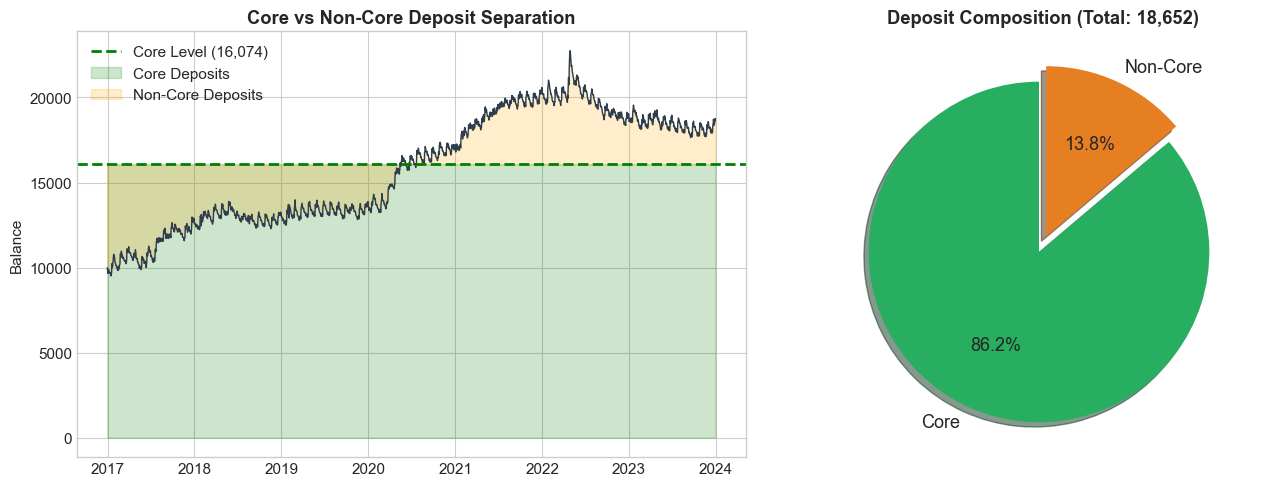

In [13]:
# Visualize Core vs Non-Core
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time series with core/non-core regions
axes[0].plot(df['Date'], df['Balance'], color='#2c3e50', linewidth=1)
axes[0].axhline(y=core_deposit_final, color='green', linestyle='--', linewidth=2, label=f'Core Level ({core_deposit_final:,.0f})')
axes[0].fill_between(df['Date'], 0, core_deposit_final, alpha=0.2, color='green', label='Core Deposits')
axes[0].fill_between(df['Date'], core_deposit_final, df['Balance'], alpha=0.2, color='orange', label='Non-Core Deposits')
axes[0].set_title('Core vs Non-Core Deposit Separation', fontweight='bold')
axes[0].set_ylabel('Balance')
axes[0].legend(loc='upper left')

# Pie chart
axes[1].pie([core_pct, non_core_pct], labels=['Core', 'Non-Core'],
            autopct='%1.1f%%', colors=['#27ae60', '#e67e22'], startangle=90,
            explode=(0.05, 0.05), shadow=True, textprops={'fontsize': 13})
axes[1].set_title(f'Deposit Composition (Total: {calc_balance:,.0f})', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Cash Flow Slotting (Basel Time Buckets)

Following Basel IRRBB standards, we slot the NMD cash flows into time buckets:
- **Non-core deposits**: Slotted into overnight bucket (immediate repricing)
- **Core deposits**: Distributed across time buckets up to 5Y regulatory cap using the decay profile

Standard Basel time buckets: O/N, 1M, 3M, 6M, 1Y, 2Y, 3Y, 4Y, 5Y

In [14]:
# === Basel Cash Flow Slotting ===

# Time buckets (in months) and their midpoints (in years) for discounting
buckets = {
    'O/N':    {'start': 0, 'end': 0, 'midpoint_years': 1/365},
    '1M':     {'start': 0, 'end': 1, 'midpoint_years': 1/24},
    '3M':     {'start': 1, 'end': 3, 'midpoint_years': 2/12},
    '6M':     {'start': 3, 'end': 6, 'midpoint_years': 4.5/12},
    '1Y':     {'start': 6, 'end': 12, 'midpoint_years': 9/12},
    '2Y':     {'start': 12, 'end': 24, 'midpoint_years': 1.5},
    '3Y':     {'start': 24, 'end': 36, 'midpoint_years': 2.5},
    '4Y':     {'start': 36, 'end': 48, 'midpoint_years': 3.5},
    '5Y':     {'start': 48, 'end': 60, 'midpoint_years': 4.5},
}

# Slot non-core deposits to O/N
# Slot core deposits using decay profile across buckets

# Core deposit decay allocation
# For each bucket, the amount is the core balance that decays within that period
core_allocation = {}
remaining_core = core_deposit_final

for bucket_name, params in buckets.items():
    if bucket_name == 'O/N':
        # Non-core goes to O/N
        core_allocation[bucket_name] = non_core_deposit_final
        continue
    
    start_m = params['start']
    end_m = params['end']
    
    # Fraction of core that decays in this bucket
    survival_start = np.exp(-avg_monthly_outflow * start_m)
    survival_end = np.exp(-avg_monthly_outflow * end_m)
    decay_in_bucket = survival_start - survival_end
    
    core_allocation[bucket_name] = core_deposit_final * decay_in_bucket

# Any remaining core that survives beyond 5Y gets slotted at 5Y (regulatory cap)
survival_5y = np.exp(-avg_monthly_outflow * 60)
core_allocation['5Y'] += core_deposit_final * survival_5y

# Create summary table
slotting_df = pd.DataFrame([
    {
        'Time Bucket': bucket,
        'Midpoint (Years)': params['midpoint_years'],
        'Cash Flow': core_allocation[bucket],
        '% of Total': core_allocation[bucket] / calc_balance * 100
    }
    for bucket, params in buckets.items()
])

print("\nBasel Cash Flow Slotting Summary")
print("=" * 65)
print(f"{'Bucket':<10} {'Midpoint(Y)':>12} {'Cash Flow':>14} {'% of Total':>12}")
print("-" * 65)
for _, row in slotting_df.iterrows():
    print(f"{row['Time Bucket']:<10} {row['Midpoint (Years)']:>12.4f} {row['Cash Flow']:>14,.2f} {row['% of Total']:>11.2f}%")
print("-" * 65)
print(f"{'TOTAL':<10} {'':<12} {slotting_df['Cash Flow'].sum():>14,.2f} {slotting_df['% of Total'].sum():>11.2f}%")


Basel Cash Flow Slotting Summary
Bucket      Midpoint(Y)      Cash Flow   % of Total
-----------------------------------------------------------------
O/N              0.0027       2,577.90       13.82%
1M               0.0417         235.81        1.26%
3M               0.1667         461.30        2.47%
6M               0.3750         666.88        3.58%
1Y               0.7500       1,248.25        6.69%
2Y               1.5000       2,187.71       11.73%
3Y               2.5000       1,832.18        9.82%
4Y               3.5000       1,534.42        8.23%
5Y               4.5000       7,907.25       42.39%
-----------------------------------------------------------------
TOTAL                        18,651.70      100.00%


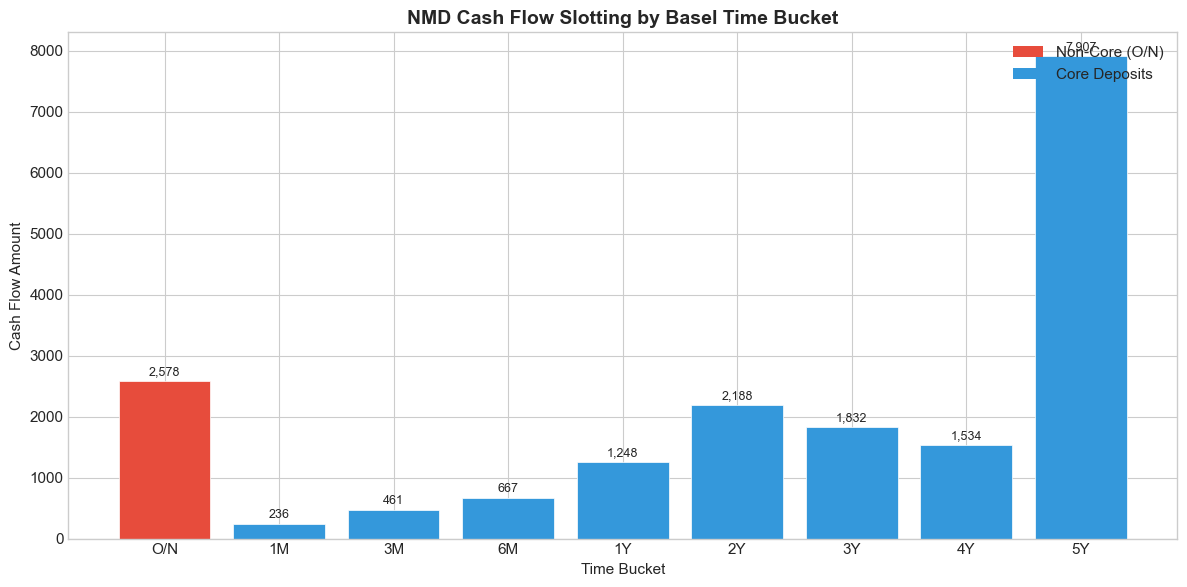

In [15]:
# Visualize Cash Flow Slotting
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#e74c3c'] + ['#3498db'] * (len(slotting_df) - 1)  # Red for O/N (non-core), Blue for core
bars = ax.bar(slotting_df['Time Bucket'], slotting_df['Cash Flow'], color=colors, edgecolor='white', linewidth=0.5)

# Add value labels
for bar, val in zip(bars, slotting_df['Cash Flow']):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 50,
            f'{val:,.0f}', ha='center', va='bottom', fontsize=9)

ax.set_title('NMD Cash Flow Slotting by Basel Time Bucket', fontsize=14, fontweight='bold')
ax.set_ylabel('Cash Flow Amount')
ax.set_xlabel('Time Bucket')

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#e74c3c', label='Non-Core (O/N)'),
                   Patch(facecolor='#3498db', label='Core Deposits')]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

## 7. Interest Rate Curve & Shock Scenarios

We define the base interest rate curve and apply 4 shock scenarios:
1. **+200bps parallel shift**
2. **-200bps parallel shift**
3. **Up rate shock** (short rates +200bps, tapering to longer tenors)
4. **Flattener** (short rates up max +200bps, long rates down min -100bps)

In [ ]:
# === Base Interest Rate Curve (from group-proj-1-curve.xlsx) ===

from scipy.interpolate import interp1d

# Load provided SGD zero-rate curve
curve_raw = pd.read_excel('group-proj-1-curve.xlsx')
curve_raw.columns = ['Tenor', 'ZeroRate']

def tenor_to_years(t):
    t = str(t).strip()
    if t.endswith('D'): return int(t[:-1]) / 365
    if t.endswith('M'): return int(t[:-1]) / 12
    if t.endswith('Y'): return int(t[:-1])
    return float(t)

curve_raw['Years'] = curve_raw['Tenor'].apply(tenor_to_years)
curve_raw = curve_raw.sort_values('Years').reset_index(drop=True)

print("Provided Zero-Rate Curve (group-proj-1-curve.xlsx):")
print(curve_raw[['Tenor','Years','ZeroRate']].to_string(index=False))

# Interpolate to 9 Basel bucket tenors
interp_fn = interp1d(curve_raw['Years'].values, curve_raw['ZeroRate'].values,
                     kind='linear', fill_value='extrapolate')

tenor_labels = ['O/N', '1M', '3M', '6M', '1Y', '2Y', '3Y', '4Y', '5Y']
tenor_years  = np.array([1/365, 1/12, 3/12, 6/12, 1.0, 2.0, 3.0, 4.0, 5.0])
base_curve   = np.maximum(interp_fn(tenor_years), 0.0)

print(f"\nInterpolated Base Curve at Basel Bucket Tenors:")
for label, yr, r in zip(tenor_labels, tenor_years, base_curve):
    print(f"  {label:<5}  {yr:.4f}Y  ->  {r*100:.4f}%")

# =====================================================================
# Shock Scenarios — Specification & Rationale
# =====================================================================

# (a) +200bps Parallel Shift
# ---------------------------
# Uniform +200bps across all tenors. No floor needed — base rates are
# all ~2.6–3.2%, so shocked rates remain positive.
shock_parallel_up = base_curve + 0.0200

# (b) -200bps Parallel Shift
# ---------------------------
# Uniform -200bps across all tenors. Floor at 0% applied per tenor
# to prevent negative rates (convention for standard stress testing).
shock_parallel_down = np.maximum(base_curve - 0.0200, 0.0)

# (c) Short Rate Up
# ------------------
# Specification: +200bps at all tenors up to and including 1Y (the
# "short end"), then linearly tapering to 0bps at 5Y.
#
# Rationale: Central bank rate hike cycles drive the short end up,
# but long-term rates are anchored by inflation expectations and term
# premium. The 1Y pivot is the conventional boundary between
# policy-driven (short) and market-driven (long) rates. Using a flat
# +200bps up to 1Y — not a taper starting at O/N — is more
# economically defensible than a straight-line taper from O/N.
#
# Formula:
#   shock(t) = +200bps             for t <= 1Y
#   shock(t) = +200bps × (5-t)/4   for 1Y < t <= 5Y  (linear taper to 0)
#   shock(t) = 0                   for t > 5Y
def short_up_shock(t):
    if t <= 1.0:
        return 0.0200
    elif t <= 5.0:
        return 0.0200 * (5.0 - t) / 4.0
    else:
        return 0.0

shock_up_short = np.maximum(
    base_curve + np.array([short_up_shock(t) for t in tenor_years]),
    0.0
)

# (d) Flattener
# --------------
# Specification: short rates up (max +200bps), long rates down (min -100bps).
# Linear interpolation between +200bps at O/N and -100bps at 5Y.
#
# Rationale: Bear-flattening environment — central bank hikes policy
# rates while long-term growth and inflation expectations fall,
# compressing the term premium at the long end.
#
# Formula: shock(t) = +200bps - 300bps × (t / 5Y)
#   At t=0:  +200bps (max, per spec)
#   At t=5Y: -100bps (min, per spec)
# Floor applied to shocked RATE (not shock) at 0% to prevent negative rates.
flatten_shock = 0.0200 - 0.0300 * tenor_years / 5.0
# Clamp shock between -100bps and +200bps (spec bounds)
flatten_shock = np.clip(flatten_shock, -0.0100, 0.0200)
shock_flattener = np.maximum(base_curve + flatten_shock, 0.0)

scenarios = {
    'Base':             base_curve,
    '+200bps Parallel': shock_parallel_up,
    '-200bps Parallel': shock_parallel_down,
    'Short Rate Up':    shock_up_short,
    'Flattener':        shock_flattener,
}

# Display full scenario table
print(f"\n{'Tenor':<6} {'Base%':>8} {'+200Par%':>10} {'-200Par%':>10} {'ShortUp%':>10} {'Flatten%':>10}")
print("-" * 57)
for i, label in enumerate(tenor_labels):
    print(f"{label:<6} {base_curve[i]*100:>8.4f} "
          f"{shock_parallel_up[i]*100:>10.4f} "
          f"{shock_parallel_down[i]*100:>10.4f} "
          f"{shock_up_short[i]*100:>10.4f} "
          f"{shock_flattener[i]*100:>10.4f}")

print(f"\nScenario (c) — Short Rate Up: +200bps flat to 1Y, linear taper to 0bps at 5Y")
print(f"Scenario (d) — Flattener: +200bps at O/N, -100bps at 5Y, linear interp, 0% floor on rate")


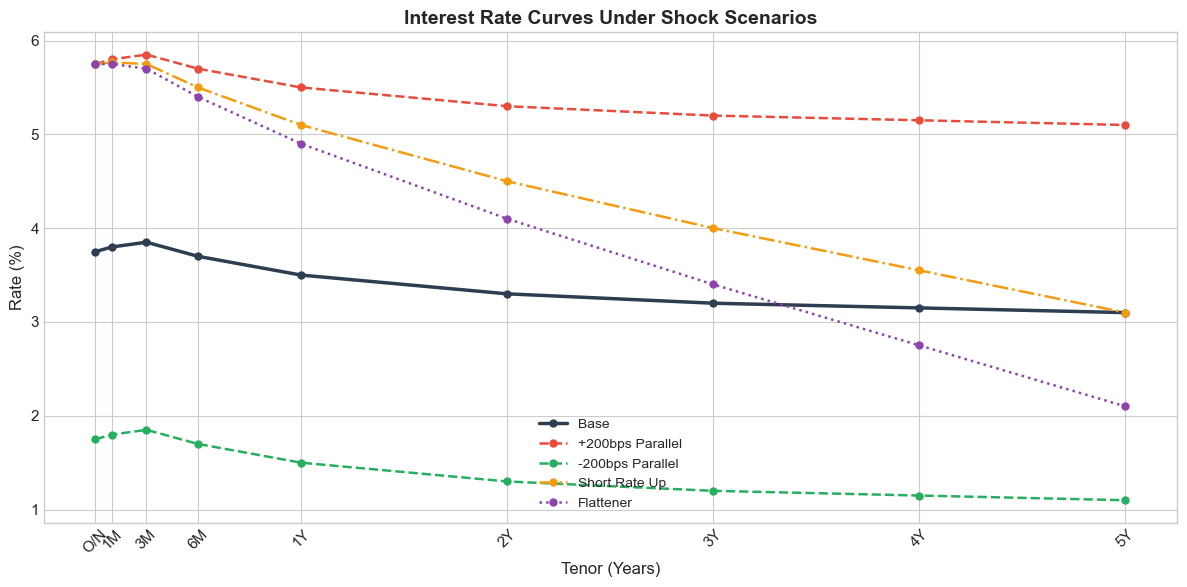

In [17]:
# Plot yield curves
fig, ax = plt.subplots(figsize=(12, 6))

colors_scenario = {'Base': '#2c3e50', '+200bps Parallel': '#e74c3c', '-200bps Parallel': '#27ae60',
                   'Short Rate Up': '#f39c12', 'Flattener': '#8e44ad'}
linestyles = {'Base': '-', '+200bps Parallel': '--', '-200bps Parallel': '--',
              'Short Rate Up': '-.', 'Flattener': ':'}

for name, curve in scenarios.items():
    ax.plot(tenor_years, curve * 100, linestyles[name], color=colors_scenario[name],
            linewidth=2.5 if name == 'Base' else 1.8, label=name, marker='o', markersize=5)

ax.set_xlabel('Tenor (Years)', fontsize=12)
ax.set_ylabel('Rate (%)', fontsize=12)
ax.set_title('Interest Rate Curves Under Shock Scenarios', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.set_xticks(tenor_years)
ax.set_xticklabels(tenor_labels, rotation=45)

plt.tight_layout()
plt.show()

## 8. EVE (Economic Value of Equity) Sensitivity

EVE measures the change in the present value of all cash flows when rates change.

$$\Delta EVE = \sum_{i} CF_i \cdot \left[ \frac{1}{(1+r^{base}_i)^{t_i}} - \frac{1}{(1+r^{shock}_i)^{t_i}} \right]$$

In [18]:
# === EVE Calculation ===

def discount_factor(rate, years):
    """Calculate discount factor"""
    return 1.0 / (1.0 + rate) ** years

def compute_pv(cash_flows, rates, midpoints):
    """Compute present value of cash flows"""
    pv = 0
    for cf, r, t in zip(cash_flows, rates, midpoints):
        pv += cf * discount_factor(r, t)
    return pv

# Cash flows from slotting
cash_flows = slotting_df['Cash Flow'].values
midpoints = slotting_df['Midpoint (Years)'].values

# Compute EVE under each scenario
eve_results = {}
for name, curve in scenarios.items():
    pv = compute_pv(cash_flows, curve, midpoints)
    eve_results[name] = pv

# Base EVE
eve_base = eve_results['Base']

# EVE sensitivities (Delta EVE)
print("\nEVE Sensitivity Analysis")
print("=" * 65)
print(f"{'Scenario':<25} {'PV (EVE)':>14} {'ΔEVE':>14} {'ΔEVE %':>10}")
print("-" * 65)

eve_deltas = {}
for name, pv in eve_results.items():
    delta = pv - eve_base
    delta_pct = delta / eve_base * 100 if eve_base != 0 else 0
    eve_deltas[name] = delta
    marker = " ← BASE" if name == 'Base' else ""
    print(f"{name:<25} {pv:>14,.2f} {delta:>14,.2f} {delta_pct:>9.4f}%{marker}")

# Worst case
shock_scenarios = {k: v for k, v in eve_deltas.items() if k != 'Base'}
worst_eve_scenario = min(shock_scenarios, key=shock_scenarios.get)
worst_eve_delta = shock_scenarios[worst_eve_scenario]
print(f"\n{'WORST CASE EVE':>25}: {worst_eve_scenario} (ΔEVE = {worst_eve_delta:,.2f})")


EVE Sensitivity Analysis
Scenario                        PV (EVE)           ΔEVE     ΔEVE %
-----------------------------------------------------------------
Base                           17,191.80           0.00    0.0000% ← BASE
+200bps Parallel               16,369.22        -822.58   -4.7847%
-200bps Parallel               18,096.09         904.29    5.2600%
Short Rate Up                  17,085.26        -106.54   -0.6197%
Flattener                      17,469.66         277.86    1.6162%

           WORST CASE EVE: +200bps Parallel (ΔEVE = -822.58)


In [19]:
# EVE breakdown by bucket
print("\nEVE Contribution by Time Bucket")
print("=" * 95)
header = f"{'Bucket':<8}"
for name in scenarios:
    header += f" {name:>16}"
print(header)
print("-" * 95)

eve_by_bucket = pd.DataFrame()
for name, curve in scenarios.items():
    pv_by_bucket = [cf * discount_factor(r, t) for cf, r, t in zip(cash_flows, curve, midpoints)]
    eve_by_bucket[name] = pv_by_bucket

eve_by_bucket.index = slotting_df['Time Bucket'].values

for bucket in eve_by_bucket.index:
    row = f"{bucket:<8}"
    for name in scenarios:
        row += f" {eve_by_bucket.loc[bucket, name]:>16,.2f}"
    print(row)

print("-" * 95)
row = f"{'TOTAL':<8}"
for name in scenarios:
    row += f" {eve_by_bucket[name].sum():>16,.2f}"
print(row)


EVE Contribution by Time Bucket
Bucket               Base +200bps Parallel -200bps Parallel    Short Rate Up        Flattener
-----------------------------------------------------------------------------------------------
O/N              2,577.64         2,577.51         2,577.78         2,577.51         2,577.51
1M                 235.45           235.26           235.64           235.26           235.27
3M                 458.40           456.95           459.89           457.02           457.06
6M                 657.86           653.16           662.68           653.62           653.86
1Y               1,216.45         1,199.12         1,234.39         1,202.54         1,204.26
2Y               2,083.72         2,024.64         2,145.74         2,047.93         2,059.75
3Y               1,693.43         1,614.09         1,778.34         1,661.05         1,685.26
4Y               1,376.58         1,287.10         1,474.22         1,358.06         1,395.43
5Y               6,892.26

## 9. NII (Net Interest Income) Sensitivity (1Y Window)

NII sensitivity measures the impact on interest income over a 1-year horizon.

For NMD:
- Interest earned = Balance in bucket × Rate × Time weight (within 1Y)
- Only cash flows within the 1Y window affect NII

In [ ]:
# === NII Calculation (1Y Window) — Corrected Repricing Mechanics ===
#
# NII over the 1Y window = sum of interest earned on each cash-flow bucket.
#
# Key principle (Basel IRRBB / gap analysis):
#
#   • SHORT buckets (start < 1Y):  These deposits reprice / roll off within
#     the 1Y window. During the period before they reprice, they earn at the
#     BASE rate. After repricing (at the start of their bucket), they earn at
#     the SHOCKED rate. The sensitivity therefore comes from the post-shock
#     portion of the year.
#
#   • LONG buckets (start ≥ 1Y):  These deposits do NOT reprice within the
#     1Y window. They are locked at the BASE rate for the full year.
#     ⟹  NII sensitivity for these buckets is ZERO (base = shocked).
#
# For each bucket, denoting:
#   start_y = start of bucket in years, end_y = end of bucket in years
#   r_base  = base rate, r_shock = shocked rate
#
# NII_base  = CF × r_base  × min(1 - start_y, 1)   (interest earned over 1Y)
# NII_shock = CF × r_shock × remaining_in_window    +  CF × r_base × pre_reprice
#           (where remaining = 1 - start_y for short buckets; 0 for long buckets)
#
# For simplicity, since the bucket represents a single repricing event at start_y:
#   ΔNII = CF × (r_shock - r_base) × max(1 - start_y, 0)

bucket_meta = [
    {'name': 'O/N', 'start_y': 0.0,        'end_y': 1/365},
    {'name': '1M',  'start_y': 0.0,        'end_y': 1/12},
    {'name': '3M',  'start_y': 1/12,       'end_y': 3/12},
    {'name': '6M',  'start_y': 3/12,       'end_y': 6/12},
    {'name': '1Y',  'start_y': 6/12,       'end_y': 12/12},
    {'name': '2Y',  'start_y': 12/12,      'end_y': 24/12},
    {'name': '3Y',  'start_y': 24/12,      'end_y': 36/12},
    {'name': '4Y',  'start_y': 36/12,      'end_y': 48/12},
    {'name': '5Y',  'start_y': 48/12,      'end_y': 60/12},
]

def compute_nii_corrected(cash_flows, shocked_rates, base_rates, bucket_meta, window=1.0):
    """
    Compute NII over a 1Y window with correct repricing mechanics.

    - Short buckets (start < 1Y): earn base rate up to repricing date, then
      the shocked rate for the remainder of the year.
    - Long buckets (start >= 1Y): locked at base rate for the full year;
      no sensitivity to the shock within the 1Y window.

    Returns total NII for the scenario.
    """
    nii = 0.0
    for cf, r_s, r_b, bkt in zip(cash_flows, shocked_rates, base_rates, bucket_meta):
        start_y = bkt['start_y']
        if start_y >= window:
            # Locked: earns base rate for full year, no shock sensitivity
            nii += cf * r_b * window
        else:
            # Reprices at start_y: pre-reprice at base, post-reprice at shocked
            pre_reprice  = start_y                  # time earning base rate
            post_reprice = window - start_y         # time earning shocked rate
            nii += cf * (r_b * pre_reprice + r_s * post_reprice)
    return nii

# Re-align bucket_meta with the slotting order in slotting_df
assert [b['name'] for b in bucket_meta] == list(slotting_df['Time Bucket']), \
    "Bucket order mismatch between slotting_df and bucket_meta — check definitions"

base_rates_aligned = np.array([
    np.interp(bkt['start_y'] if bkt['start_y'] > 0 else 1/365,
              tenor_years, scenarios['Base'])
    for bkt in bucket_meta
])

# Compute NII for each scenario
nii_results = {}
for name, curve in scenarios.items():
    scenario_rates = np.array([
        np.interp(bkt['start_y'] if bkt['start_y'] > 0 else 1/365,
                  tenor_years, curve)
        for bkt in bucket_meta
    ])
    nii_results[name] = compute_nii_corrected(
        cash_flows, scenario_rates, base_rates_aligned, bucket_meta
    )

nii_base = nii_results['Base']

print("NII Sensitivity Analysis (1Y Window — Corrected Repricing Mechanics)")
print("=" * 70)
print(f"{'Scenario':<25} {'NII':>14} {'ΔNII':>14} {'ΔNII %':>10}")
print("-" * 70)

nii_deltas = {}
for name, nii in nii_results.items():
    delta     = nii - nii_base
    delta_pct = delta / nii_base * 100 if nii_base != 0 else 0
    nii_deltas[name] = delta
    marker = " ← BASE" if name == 'Base' else ""
    print(f"{name:<25} {nii:>14,.2f} {delta:>14,.2f} {delta_pct:>9.4f}%{marker}")

# Worst case (most negative ΔNII)
shock_nii        = {k: v for k, v in nii_deltas.items() if k != 'Base'}
worst_nii_scenario = min(shock_nii, key=shock_nii.get)
worst_nii_delta    = shock_nii[worst_nii_scenario]
print(f"\n{'WORST CASE NII':>25}: {worst_nii_scenario} (ΔNII = {worst_nii_delta:,.2f})")

# ── Repricing sensitivity breakdown by bucket ─────────────────────────────
print("\nΔNII Breakdown by Bucket (for +200bps Parallel scenario):")
print(f"  {'Bucket':<8} {'CF':>12} {'Start(Y)':>10} {'RepriceFrac':>13} {'ΔNII':>12}")
print(f"  {'-'*57}")
shock_curve_aligned = np.array([
    np.interp(bkt['start_y'] if bkt['start_y'] > 0 else 1/365,
              tenor_years, scenarios['+200bps Parallel'])
    for bkt in bucket_meta
])
for cf, r_s, r_b, bkt in zip(cash_flows, shock_curve_aligned, base_rates_aligned, bucket_meta):
    start_y      = bkt['start_y']
    reprice_frac = max(1.0 - start_y, 0.0)   # fraction of year at shocked rate
    delta_nii_bkt = cf * (r_s - r_b) * reprice_frac
    print(f"  {bkt['name']:<8} {cf:>12,.2f} {start_y:>10.4f} {reprice_frac:>13.4f} {delta_nii_bkt:>12,.2f}")


## 10. IRRBB Reporting Summary

The final IRRBB measures for regulatory reporting, taking the worst-case outcomes across all shock scenarios.

In [21]:
# === FINAL IRRBB REPORTING SUMMARY ===

print("╔" + "═" * 68 + "╗")
print("║" + " IRRBB REPORTING SUMMARY - NMD Account Cohort".center(68) + "║")
print("║" + " SMU Bank | Calculation Date: 31-Dec-2023".center(68) + "║")
print("╠" + "═" * 68 + "╣")

print("║" + "".center(68) + "║")
print("║" + " 1. NMD BALANCE & COMPOSITION".ljust(68) + "║")
print("║" + f"    Total NMD Balance:        {calc_balance:>14,.2f}".ljust(68) + "║")
print("║" + f"    Core Deposits:            {core_deposit_final:>14,.2f} ({core_pct:.1%})".ljust(68) + "║")
print("║" + f"    Non-Core Deposits:        {non_core_deposit_final:>14,.2f} ({non_core_pct:.1%})".ljust(68) + "║")
print("║" + f"    Regulatory Cap:           5 Years".ljust(68) + "║")

print("║" + "".center(68) + "║")
print("║" + " 2. DEPOSIT DECAY PARAMETERS".ljust(68) + "║")
print("║" + f"    Avg Daily Outflow Rate:   {avg_daily_decay:.6f}".ljust(68) + "║")
print("║" + f"    Avg Monthly Outflow Rate: {avg_monthly_outflow:.4%}".ljust(68) + "║")
half_life_m = np.log(2) / avg_monthly_outflow if avg_monthly_outflow > 0 else 999
print("║" + f"    Implied Half-Life:        {half_life_m:.1f} months ({half_life_m/12:.1f} years)".ljust(68) + "║")

print("║" + "".center(68) + "║")
print("║" + " 3. EVE SENSITIVITY".ljust(68) + "║")
print("║" + f"    Base EVE:                 {eve_base:>14,.2f}".ljust(68) + "║")
for name in ['+200bps Parallel', '-200bps Parallel', 'Short Rate Up', 'Flattener']:
    d = eve_deltas[name]
    print("║" + f"    {name:<22}  ΔEVE = {d:>+12,.2f}".ljust(68) + "║")
print("║" + f"    ► WORST CASE: {worst_eve_scenario} (ΔEVE = {worst_eve_delta:>+,.2f})".ljust(68) + "║")

print("║" + "".center(68) + "║")
print("║" + " 4. NII SENSITIVITY (1Y Window)".ljust(68) + "║")
print("║" + f"    Base NII:                 {nii_base:>14,.2f}".ljust(68) + "║")
for name in ['+200bps Parallel', '-200bps Parallel', 'Short Rate Up', 'Flattener']:
    d = nii_deltas[name]
    print("║" + f"    {name:<22}  ΔNII = {d:>+12,.2f}".ljust(68) + "║")
print("║" + f"    ► WORST CASE: {worst_nii_scenario} (ΔNII = {worst_nii_delta:>+,.2f})".ljust(68) + "║")

print("║" + "".center(68) + "║")
print("║" + " 5. ML MODEL PERFORMANCE (Outflow Rate Prediction)".ljust(68) + "║")
ens_r2 = r2_score(y_test, ensemble_pred)
ens_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
print("║" + f"    Ensemble R²:              {ens_r2:.4f}".ljust(68) + "║")
print("║" + f"    Ensemble RMSE:            {ens_rmse:.6f}".ljust(68) + "║")

print("╚" + "═" * 68 + "╝")

╔════════════════════════════════════════════════════════════════════╗
║            IRRBB REPORTING SUMMARY - NMD Account Cohort            ║
║              SMU Bank | Calculation Date: 31-Dec-2023              ║
╠════════════════════════════════════════════════════════════════════╣
║                                                                    ║
║ 1. NMD BALANCE & COMPOSITION                                       ║
║    Total NMD Balance:             18,651.70                        ║
║    Core Deposits:                 16,073.80 (86.2%)                ║
║    Non-Core Deposits:              2,577.90 (13.8%)                ║
║    Regulatory Cap:           5 Years                               ║
║                                                                    ║
║ 2. DEPOSIT DECAY PARAMETERS                                        ║
║    Avg Daily Outflow Rate:   0.018561                              ║
║    Avg Monthly Outflow Rate: 1.4779%                               ║
║    I

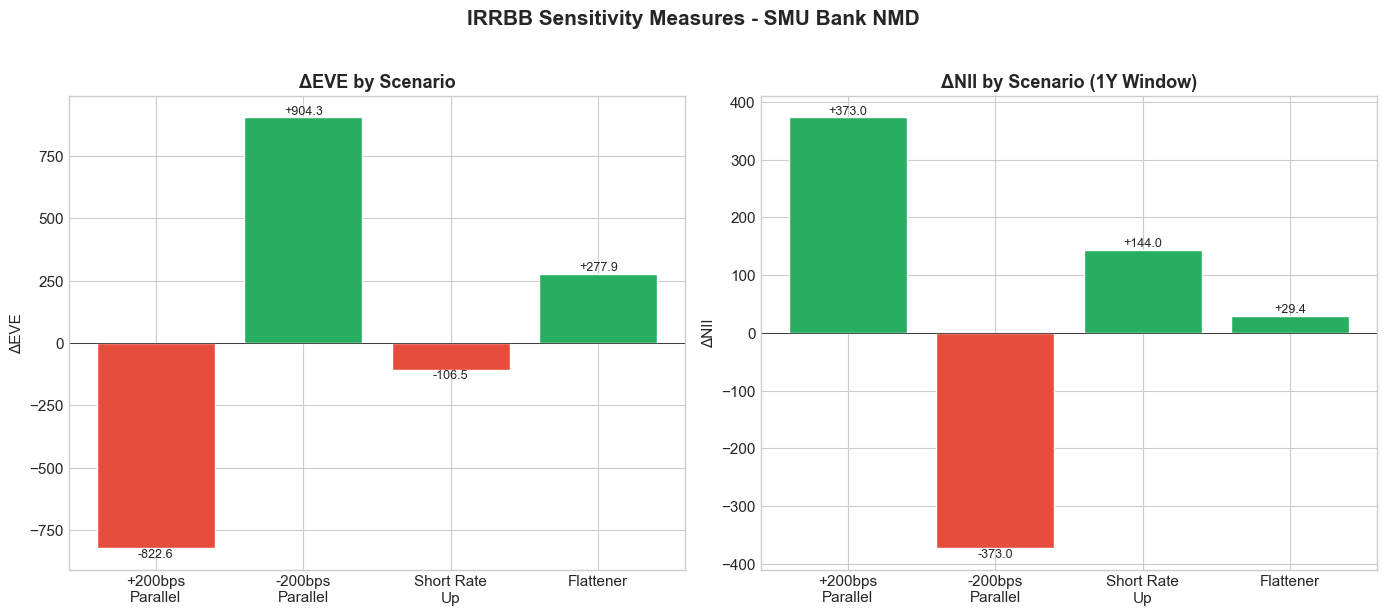


✅ IRRBB Analysis Complete.

IRRBB Measures for Reporting:
  EVE measure: ΔEVE = -822.58 (+200bps Parallel)
  NII measure: ΔNII = -373.03 (-200bps Parallel)


In [22]:
# Final visualization: EVE and NII sensitivity comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# EVE
scenario_names = ['+200bps\nParallel', '-200bps\nParallel', 'Short Rate\nUp', 'Flattener']
eve_vals = [eve_deltas[s] for s in ['+200bps Parallel', '-200bps Parallel', 'Short Rate Up', 'Flattener']]
colors_bar = ['#e74c3c' if v < 0 else '#27ae60' for v in eve_vals]

bars1 = axes[0].bar(scenario_names, eve_vals, color=colors_bar, edgecolor='white')
axes[0].axhline(y=0, color='black', linewidth=0.5)
axes[0].set_title('ΔEVE by Scenario', fontsize=13, fontweight='bold')
axes[0].set_ylabel('ΔEVE')
for bar, val in zip(bars1, eve_vals):
    axes[0].text(bar.get_x() + bar.get_width()/2., val, f'{val:+,.1f}',
                ha='center', va='bottom' if val > 0 else 'top', fontsize=9)

# NII
nii_vals = [nii_deltas[s] for s in ['+200bps Parallel', '-200bps Parallel', 'Short Rate Up', 'Flattener']]
colors_bar2 = ['#e74c3c' if v < 0 else '#27ae60' for v in nii_vals]

bars2 = axes[1].bar(scenario_names, nii_vals, color=colors_bar2, edgecolor='white')
axes[1].axhline(y=0, color='black', linewidth=0.5)
axes[1].set_title('ΔNII by Scenario (1Y Window)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('ΔNII')
for bar, val in zip(bars2, nii_vals):
    axes[1].text(bar.get_x() + bar.get_width()/2., val, f'{val:+,.1f}',
                ha='center', va='bottom' if val > 0 else 'top', fontsize=9)

plt.suptitle('IRRBB Sensitivity Measures - SMU Bank NMD', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✅ IRRBB Analysis Complete.")
print(f"\nIRRBB Measures for Reporting:")
print(f"  EVE measure: ΔEVE = {worst_eve_delta:+,.2f} ({worst_eve_scenario})")
print(f"  NII measure: ΔNII = {worst_nii_delta:+,.2f} ({worst_nii_scenario})")